# PyTorch を使ったニューラルネットワークの作り方
ニューラルネットワークは、非線形なデータに対しても非常に有効な機械学習の手法です。

[PyTorch](https://pytorch.org/) はこのニューラルネットワークのモデルを構築するのに便利な Python ライブラリになります。

今回は、この PyTorch を使ってニューラルネットワークをどのように組み立てるのかについてのチュートリアルをしていきましょう！

## イントロダクション
まずは基本的なことですが、機械学習というものがどうなっているのかについて軽く解説します。

機械学習とは、一言で言うと「データの内部に存在する特徴を機械的に解釈し、一般化を目指す」ものです。

機械学習の種類はいくつかありますが、代表的なものとして以下の2つを挙げます。

- 教師あり学習
    - 分類、回帰
- 教師なし学習
    - クラスタリング

前者は、

> あるデータが与えられ、そのデータの特徴を表す ***説明変数*** というものと、説明変数から記述できそうと考えられる ***目的変数(従属変数)*** というものが存在する場合、説明変数と目的変数を一緒に学習させることによって、未知のデータの説明変数からそれらの目的変数を予測するというもの

です。

後者は、

> あるデータが与えられ、その中にデータ間の明示的な差異がない場合、それらに一定の方針のもと価値を付与するもの

です。

教師なし学習については今回はあまり深掘りしないで、教師あり学習に絞って説明していきます。

### 教師あり学習 - 分類問題
分類問題とは、

> 目的変数が離散値(基本は整数値)であり、ラベルと呼ばれるものを予測する問題

です。

元のデータのラベル(目的変数)は数値データでなくても問題ありません。

例えば、

[$n$ 種類の動物の名前] $\rightarrow$ [$0, 1, ..., n - 1$]

というように前処理を行えばOKです。

### 教師あり学習 - 回帰問題
回帰問題とは、

> 目的変数が連続値であり、入力(説明変数)に対して目的変数の値を返す関数を作る(近似する)ように学習させる問題

です。

## ニューラルネットワーク
さて、機械学習のタスクについてはこの程度にしておいて、いよいよ本題のニューラルネットワークの手法について説明します。

もちろん現在も重回帰分析などの単純なモデルが実務で使われることが多くありますが、より高度なことができるとニューラルネットワークをベースにしたモデルが近年積極的に使われています。

代表例として Stable Diffusion や ChatGPT なども、ニューラルネットワークを土台にさらに進化させたモデルで作られています。

### データ構造
基本的に入力となる説明変数、及び出力となる目的変数共に数値データである必要があります。

$n$ 個(次元)の説明変数と、

分類問題ならラベルの種類のベクトルに対応する位置のみ $1$ とし、他は $0$ とした目的変数を(諸説あり)、

回帰問題なら連続値の値そのものである目的変数を、

入力できる形に前処理します。

$$
\boldsymbol{X} = 
\begin{bmatrix}
x_{0,0} & x_{0,1} & \cdots & x_{0,n-1} \\
x_{1,0} & x_{1,1} & \cdots & x_{1,n-1}\\
\vdots & \vdots & \ddots & \vdots \\
x_{m-1,0} & x_{m-1,1} & \cdots & x_{m-1,n-1}
\end{bmatrix}
, \space \space \space \space \space
\boldsymbol{y} = 
\begin{bmatrix}
y_{0} \\
y_{1} \\
\vdots \\
y_{m-1}
\end{bmatrix}
\space
\left(
    or \space
    \boldsymbol{y} = 
    \begin{bmatrix}
    y_{0,0} & y_{0,1} & \cdots & y_{0,n-1} \\
    y_{1,0} & y_{1,1} & \cdots & y_{1,n-1}\\
    \vdots & \vdots & \ddots & \vdots \\
    y_{m-1,0} & y_{m-1,1} & \cdots & y_{m-1,n-1}
    \end{bmatrix}
\right)
$$


### ネットワーク

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plotter(title, x_list, y_list):
    plt.figure(figsize=(8, 6))

    plt.title(title, size=15, color='red')
    plt.plot(x_list, y_list)
    plt.grid()

    plt.show()

![ネットワーク](ニューラルネット.png)

なぜ中間層で使われる非線形関数が、線形関数ではいけないかについて少し説明を入れます。

まず、ここにある変換の関数のことを一般的に ***活性化関数*** と呼びます。

この活性化関数が線形関数であると仮定すると、例えば $f(x) = ax + b$ として中間層を3層にすると、 $g(x) = f(f(f(x)))$ のようにまとめることができます。

これを計算すると、 $g(x) = a^3x + c$ というように表すことができ、ひとまとめにできるので3層分の深みが意味をなさなくなってしまいます。

層を深くすることに意味を持たせるためには、ここに非線形関数を用いる必要があるということです。

実際に活性化関数にはどのようなものを使っているのか見てみましょう。

1. ステップ関数
$$
f(x) = 
\left \lbrace
\begin{matrix}
0 \space \space \space (x \leq 0) \\ 
1 \space \space \space (x > 0)
\end{matrix}
\right.
$$

In [3]:
def step(x):
    if x <= 0:
        return 0
    else:
        return 1

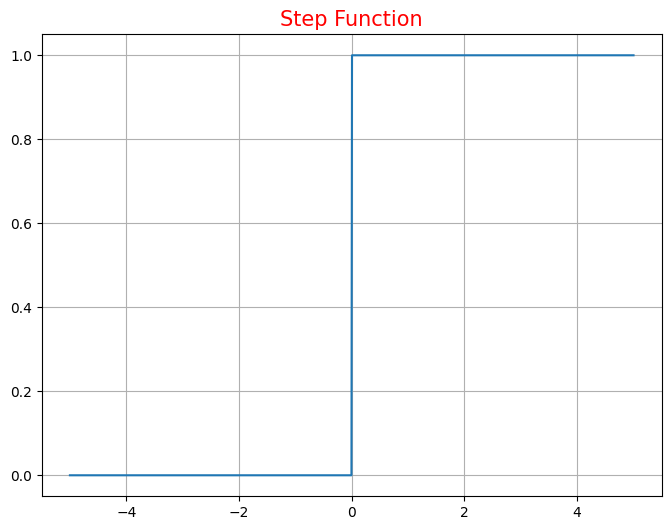

In [4]:
x_list = np.linspace(-5, 5, 1000)
y_list = [step(x) for x in x_list]

plotter('Step Function', x_list, y_list)

2. シグモイド関数
$$
f(x) = \frac{1}{1 + \exp(-x)}
$$

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

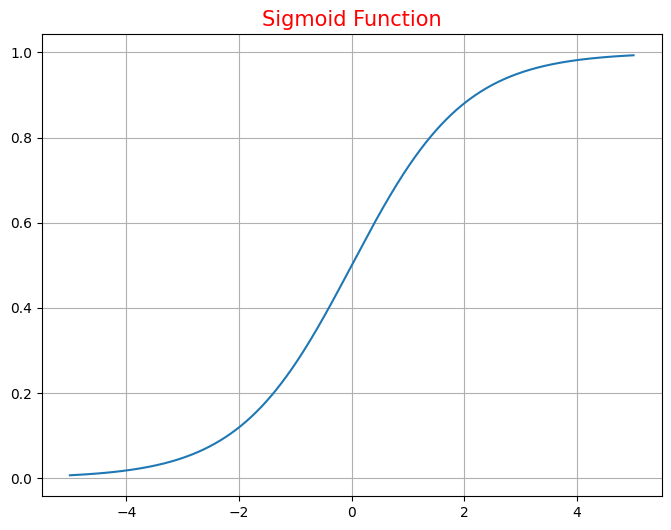

In [6]:
x_list = np.linspace(-5, 5, 1000)
y_list = [sigmoid(x) for x in x_list]

plotter('Sigmoid Function', x_list, y_list)

3. ReLU関数
$$
f(x) = 
\left \lbrace
\begin{matrix}
x \space \space \space (x > 0) \\ 
0 \space \space \space (x \leq 0)
\end{matrix}
\right.
$$

In [7]:
def relu(x):
    if x > 0:
        return x
    else:
        return 0

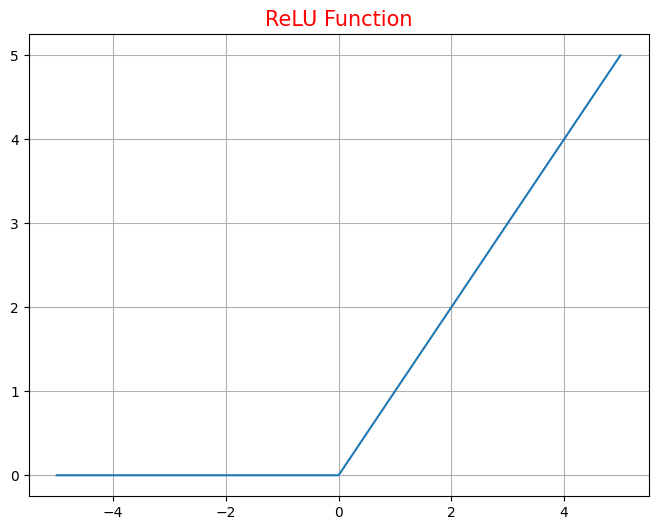

In [8]:
x_list = np.linspace(-5, 5, 1000)
y_list = [relu(x) for x in x_list]

plotter('ReLU Function', x_list, y_list)

### 誤差逆伝播法
先ほどの図では、順方向に重みをかけて足してを繰り返して出力層に繋げていましたが、これではデータを更新するたびに出力が変わり続けて何をしているのかわかりません。

![学習できない](学習できない.png)

では、どのようにすると学習できるのでしょうか。

ここには1つ誤りがあり、出力層には普通目的変数の正しい値は出てきません。

順方向に計算していった結果と、目的変数の正しい値の誤差を計算し、それを逆方向に伝播します。

これを ***誤差逆伝播法*** と言います。

![誤差逆伝播法](誤差逆伝播.png)

## チュートリアル
Scikit-Learn の[糖尿病患者のデータセット](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes)を用いて、疾患の進行度を定量的に予測する回帰問題をニューラルネットワークで解いてみましょう。

### データのロード

In [9]:
from sklearn.datasets import load_diabetes

In [10]:
data = load_diabetes()
print(data.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

データの情報を見ると、全データ数は442個です。

説明変数は10個(年齢、性別、BMI、血圧、その他6種の血清)あり、目的変数はベースラインとなる年から1年後の疾患の進行状況を定量的に測定した値となっています。

### 前処理

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = data.data
y = data.target

説明変数を `X` とし、目的変数を `y` としました。

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=8192)
X_valid, X_eval, y_valid, y_eval = train_test_split(X_test, y_test, test_size=0.50, random_state=8192)

ここでは、 `train_test_split` という関数を用いて、データを学習用とテスト用に分けることをします。

2行目ではまた、テストデータを開発用と評価用の2つに分けました。

どちらも再現性が取れるように seed 値を固定しています。

現在は、

- モデルで学習するためのデータ (`X_train`, `y_train`, 全体の6割)
- モデルで学習をしている最中にどれだけ汎化能力があるかを調べるデータ (`X_valid`, `y_valid`, 全体の2割)
- 学習を終えたモデルで実際に評価するためのデータ (`X_eval`, `y_eval`, 全体の2割)

というふうにデータを分けてみました。

### PyTorch を使って学習できるようにデータを更に処理

In [14]:
import numpy as np
import torch

In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

まず、 `X_train`, `y_train` それぞれを Numpy の `ndarray` 型に変換し、それを PyTorch が有する `Tensor` 型にします。

最後の `.float()` というのは後で計算上 float として見なければいけない場面があるからこのようにしています。

さて、この処理を開発用データと評価用データにもしてあげなければいけないので、一旦関数化しておきましょう。

In [16]:
def list_to_torch(X, y):
    X = np.array(X)
    y = np.array(y)

    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()

    return X, y

これでコードを簡単にできますね。

今回もう既に学習用データの方は変換してしまっているので、今作った関数を他のデータに適用してあげましょう。

In [17]:
X_valid, y_valid = list_to_torch(X_valid, y_valid)
X_eval, y_eval = list_to_torch(X_eval, y_eval)

次に、学習を進める際にモデルがデータを読み込めるように整形してあげましょう。

In [18]:
from torch.utils.data import TensorDataset, DataLoader

In [19]:
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

これは学習中にしか必要ないので、評価用のデータに適用してあげる必要はありません。

そして、これだけではまだ不十分です。

このデータセットを `DataLoader` という型に落とし込む作業をします。

ここで、バッチサイズを指定します。

バッチサイズというのは、簡単に言うと「全てのデータを学習するのが大変なので、グループに分けてあげることで学習の効率化を図ろうという試みがあり(ミニバッチ学習)、そのグループの一つ一つの大きさ」を言います。

これは、扱うデータの総数やモデルの規模などによって最適な値が変わってくるので、とりあえず何がベストかというのはありません。

今回はデータ量もそう無いのでバッチサイズは $1$ としましょう。

In [20]:
batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

これで全ての前処理が終わりです。

### ニューラルネットワークモデルの構築

In [21]:
from torch import nn

いよいよモデルを作成していきます。

PyTorch にはニューラルネットワークを作成するためのフレームワークが沢山存在しており、クラス継承の `super()` を使ってオリジナルモデルを作るのが一般的です。

正直ここら辺については理解するより慣れた方が良いです。

自分はぶっちゃけそうしましたので、どうしても理解したいという方はインターネット上で情報をかき集めて調査してみてください。

そうでもなければ「おまじない」として覚えてしまいましょう。

```python
class Net(nn.Module):
    def __init__(self):
        super().__init__()
```

普通の class の使い方をするのですが、 `Net()` の引数に継承元を指定し、3行目の `__init__()` の下で `super().__init__()` とすることで出来ます。

後はレイヤー(層)を定義しましょう。

In [ ]:
flatten = nn.Flatten()
linear_relu_stack = nn.Sequential(
    nn.Linear(10, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 1)
)

まずは一番上の `nn.Flatten()` ですが、これは `Tensor` 型のデータを1次元化します。

入力層に入れる際に必要な処理ということですね。

そして、 `nn.Sequential()` は何となくわかるとは思いますが、この中に中間層のレイヤーを敷き詰めてあげるものになります。

これはわざわざ使わなくても問題はありませんが、色々と便利なので今回は使用しました。

そしてその `nn.Sequential()` の中の2種類のレイヤーですが、 `nn.Linear(in, out)` は in の次元から out の次元への線形変換(写像)をしており、 `nn.ReLU()` は活性化関数に ReLU 関数を使うという意味になります。

上記の例では、データの次元が

10 → 32 → 8 → 1

というふうに変化する3層のニューラルネットワークになるということです。

しかしこれ(定義)だけでは順方向の流れは作れないので、クラス内に `forward()` という関数を作ってモデルの実行ができるようにします。

ここで、関数名は他のものを使ってはいけません(`super()` で `nn.Module` の継承を行っているため)。

また、逆順に誤差を伝播するための関数は定義する必要はありません(後で出てきますが、 `Tensor` 型に `backward()` という関数が付いているからです)。

それでは全体をまとめて `NeuralNetwork` という名前のクラスを作りましょう。

In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear_relu_stack(x)
        return outputs

モデルの構築は出来ました。

次に、 PyTorch ではモデルを学習させる際に、 CPU で学習させるか GPU で学習をさせるかなどの設定が出来ます。

一般的には GPU(cuda) が使える環境ではモデルを GPU 学習の仕様に変更し、ローカルの CPU でしか扱えなければそのままにします。

それをコードに書き起こすと次のようになります。

In [23]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

これで自分の環境に合わせて、 `device` という変数を使って選択ができるようになりました。

これでモデルのインスタンスを作れば準備完了です。

In [24]:
model = NeuralNetwork().to(device)

最後の `.to(device)` で環境に適応した学習ができるモデルの選択が出来ました。

### 学習用の最適化器と損失関数の設定

In [25]:
from torch.optim import SGD

In [26]:
optimizer = SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

最適化器とは、評価したい関数のパラメータの値を変更することでより良い値に(最小化 or 最大化)するための一連の処理の手法を指します。

ここでは、 `SGD` というものを使いました。

この SGD (Stochastic Gradient Descent、確率的勾配降下法) は、ニューラルネットワークの最適化にしばしば使われる勾配ベースの最適化を行う手法になります。

ここでは詳しくは説明しませんが、他のモデル(Adam や Momentum)と一緒に勉強しておくと良いかもしれないですね。

この `SGD` の引数に `lr` というものがありますが、これは学習率(learning rate)というものであり、繰り返し学習をする中で前に学習したものより優先度を下げて学習するように仕向けているものになります。

これをすることで学習データに過度な信頼を置かないので、所謂「過学習」を抑えることが出来ます。

では次に2行目ですが、こちらは「損失関数」と呼ばれるものになります。

損失関数の役割は、出来上がったモデル(学習中のモデル)がどの程度信頼できるかを測るためのもので、真の値とモデルの予測値を比較し、その誤差を計算することで評価をします。

今回の `MSELoss` というのは、平均二乗誤差というもので、真の値とモデルの予測値の差をそれぞれ計算し、それらを2乗して平均を取った値を返します。

よって常に $0$ 以上であり、この関数が返す値が $0$ に近ければ近いほど精度良くモデルが学習されていると考えられるわけです。

### モデルの学習

In [27]:
from tqdm import tqdm

In [28]:
def model_train(epochs, train_dataloader, valid_dataloader, model, optimizer, criterion, batch_size):
    dataloader_dict = {
        'Train': train_dataloader,
        'Valid': valid_dataloader
    }

    training_data = []
    with tqdm(range(epochs)) as pbar_epoch:
        for epoch in pbar_epoch:
            pbar_epoch.set_description(f'epoch : {epoch + 1}')
            metas = []
            for phase in ['Train', 'Valid']:
                if phase == 'Train':
                    model.train()
                else:
                    model.eval()

                epoch_loss = 0.0

                for inputs, label in dataloader_dict[phase]:
                    inputs = inputs.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, label) ** 0.5

                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                        epoch_loss += loss.item() * inputs.size(0)

                epoch_loss = epoch_loss / (len(dataloader_dict[phase].dataset) * batch_size)

                meta = {'Loss': epoch_loss}
                metas.append(meta)

            training_data.append(dict(zip(['Train', 'Valid'], metas)))
    
    return model, training_data

いきなり学習用の関数を定義してしまい、今までとは説明の順序が逆になってしまいましたが、それだけこのモデルの学習の仕方が複雑だということです。

順番に説明をしていきます。

```python
dataloader_dict = {
    'Train': train_dataloader,
    'Valid': valid_dataloader
}
```

ここでは、先ほど定義した `train_dataloader` と `valid_dataloader` に対し、辞書のインデックスを振りました。

この作業は必須では無いですが、後で便利になります。

```python
training_data = []
```

これはモデルを学習している過程を把握(可視化)できるように、学習の度に学習ロスを加えていくための空のリストになります。

学習そのものには影響はありません。

```python
with tqdm(range(epochs)) as pbar_epoch:
    for epoch in pbar_epoch:
        pbar_epoch.set_description(f'epoch : {epoch + 1}')
```

1つ、機械学習に限らず非常に便利な機能をご紹介します。

[tqdm](https://tqdm.github.io/) というライブラリがあり、これは再起的なプログラムにおいて、「どれくらい終わったのか」や「あとどれくらいかかりそうなのか」というものをプログレスバーを使って確認できるものです。

使い方は非常に簡単で、 `range` を `tqdm` で囲うだけですが、実際の繰り返し命令はwith構文の下にあるということは注意です。

ここでちゃっかり出てきている `epoch` というものですが、これは学習を回す単位を表します。

データはある分だけ学習させたいと思うのが普通なので、基本的には

(バッチサイズ) $\times$ (エポック数) $\geq$ (学習データの総数)

で考えます。

しかし、データの質によっては学習の過程で「これから先どれだけ学習させても精度が良くはならない」という状況に陥ることがよくあります。

このまま学習を続けても時間やメモリの無駄であるだけでなく、場合によっては過学習が起きてしまう可能性もあります。

そういうときには「アーリーストッピング」というものを使ってあげることがあるのですが、今回は経験的にエポック数を適切に指定することで避けてみます。

```python
metas = []
```

こちらは学習用と検証用のデータのロスを記録するための空のリストになります。

さて、ここまではモデルの学習に「あったら便利な機能」くらいであり、必須では無いので切り捨ててしまっても大きな問題にはなりません。

実際にモデルを学習させるためのプロセスは次からになりますので、ここからはしっかり着いてきてください。

```python
for phase in ['Train', 'Valid']:
    if phase == 'Train':
        model.train()
    else:
        model.eval()
```

まず、ここから下の処理の分岐を考えます。

学習させるフェーズと検証するフェーズに分けてそれぞれでまとめて行います。

ここで、 `['Train', 'Valid']` とあるように、2つのフェーズに合わせてこのインデックスを指定することで `DataLoader` を使い分けられます。

まずは学習のフェーズのとき、 `model.train()` とすることでモデルを学習モードにすることができます。

反対に、検証のフェーズでは `model.eval()` とすることでモデルを評価モードにすることができます。

```python
epoch_loss = 0.0
```

続いてエポックのロスを初期化します。

ここに後で足し合わせていく実装です。

```python
for inputs, label in dataloader_dict[phase]:
    inputs = inputs.to(device)
    label = label.to(device)
```

さらに中にfor文を作りますが、ここでは、今のフェーズにおける `DataLoader` の中にある説明変数(`inputs`)と目的変数(`label`)を各ミニバッチごとに扱っていく流れになります。

まず、 `inputs` と `label` はそれぞれ `Tensor` 型であるので、どのデバイスで学習を行うかを指定する必要があります。

上で既に

```python
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
```

と指定しているので、あとはこの `device` の中に沿うように考えればOKです。

```python
optimizer.zero_grad()
```

次にここで、勾配降下法の計算を正しく行うためにモデル内のパラメータの勾配を初期化します。

詳しくは触れませんが、これは PyTorch の実装上の仕様に関わるものであり、これをしておかないと新しい勾配が古い勾配の足し合わせのようになってしまうからです。

```python
with torch.set_grad_enabled(phase == 'Train'):
    outputs = model(inputs)
    loss = criterion(outputs, label) ** 0.5
```

まず、 `.set_grad_enabled` で引数に学習フェーズであることを指定して、勾配の計算は学習時のみすることを約束します。

この約束のもとで、そのエポックの時点でのモデルの返り値を `outputs` として入れます。

ここに、先ほど指定した損失関数、今回は MSE でしたが、これで真の目的変数(`label`)と予測値(`outputs`)の誤差を計算します。

さて、その結果の後ろに `** 0.5` とありますが、なぜここでルートを取っているのでしょうか。

順を追って疑問にお答えしますと、まず第一に、ルートを取る理由としては「取らなければロスが膨大になり、学習の質が非常に劣悪になるから」です。

これは、勾配降下法を取っている以上、ロスを減らすように学習を進めていきたいのにも関わらず、その肝心のロスが膨大過ぎるとそれを減らす方向に上手く最適化してくれなくなるからです。

また、指標の単位としても MSE では2乗の形となり、解釈が難しくなる一方で、ルートを取ったものは元の単位で考えることができるという利点もあります。

第二に、ルートを取ったからそれが改善される理由としては、「2次のロスと1次のロスでは収束のし方がまるで違うため、少ないデータでも効率よく学習が進められるから」です。

これは1度自分の目で確かめた方が早いですが、今回の糖尿病患者のデータではただの MSE は全然使い物になりませんでした。

最後に、そもそも MSE ではなく MAE (平均絶対誤差) にすれば良いのではないかという疑問があると思われますが、これについては「MAE は小さな値の誤差が見えにくいという欠点があり、2乗をしてあげることで間違いをより重要視できるから」です。

誤差そのものの平均を取るのと、誤差を2乗して平均を取ったものにルートをかけるのでは全く違いますね。

```python
if phase == 'Train':
    loss.backward()
    optimizer.step()
```

学習のフェーズ時のみロスを逆伝播し、最適化を進める命令がこちらになります。

ここの `.backward()` が逆伝播の役割を担うので、モデルの中で関数を定義する必要がなかったんでしたね。

```python
epoch_loss += loss.item() * inputs.size(0)
```

そして上で定義したエポックごとのロスに、今の時点のロスを足していきます。

```python
epoch_loss = epoch_loss / (len(dataloader_dict[phase].dataset) * batch_size)

meta = {'Loss': epoch_loss}
metas.append(meta)
```

`DataLoader` の中のデータについて全てロスを足し合わせたら、あとは1データ分(バッチサイズでは無い)のロスが平均でどのくらいかを算出します。

そしてその値を `metas` に付け加えていくことで、学習用データと検証データそれぞれの学習中のロスの推移を記録することが出来ます。

```python
training_data.append(dict(zip(['Train', 'Valid'], metas)))
```

最後に `training_data` にロスのまとめを `dict` 型で保存し、それを返せるようにして終わりです。

関数全体のコードは既に上にあるので、引数をどのようにしているかだけ確認しましょう。

```python
model_train(epochs, train_dataloader, valid_dataloader, model, optimizer, criterion, batch_size)
```

順番に

- `epochs` : エポック数
- `train_dataloader` : 学習用の `DataLoader`
- `valid_dataloader` : 検証用の `DataLoader`
- `model` : 使用するモデルのアーキテクチャー
- `optimizer` : 最適化器
- `criterion` : 損失関数
- `batch_size` : バッチサイズ

です。

これらを正しく入れて学習してみましょう。

In [29]:
model, training_data = model_train(
    epochs=100,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch_size=batch_size
)

epoch : 1:   0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
epoch : 100: 100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


これで学習ができました。

### 学習結果の確認

In [30]:
import matplotlib.pyplot as plt

In [31]:
def plot_data(training_data, mode):
    train_y = [training_data[i]['Train'][mode] for i in range(len(training_data))]
    valid_y = [training_data[i]['Valid'][mode] for i in range(len(training_data))]

    x = [i + 1 for i in range(len(train_y))]

    plt.figure(figsize=(18, 12))
    plt.title(f'{mode} comparison', size=15, color='red')
    plt.grid()

    plt.plot(x, train_y, label='Train')
    plt.plot(x, valid_y, label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel(mode)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()

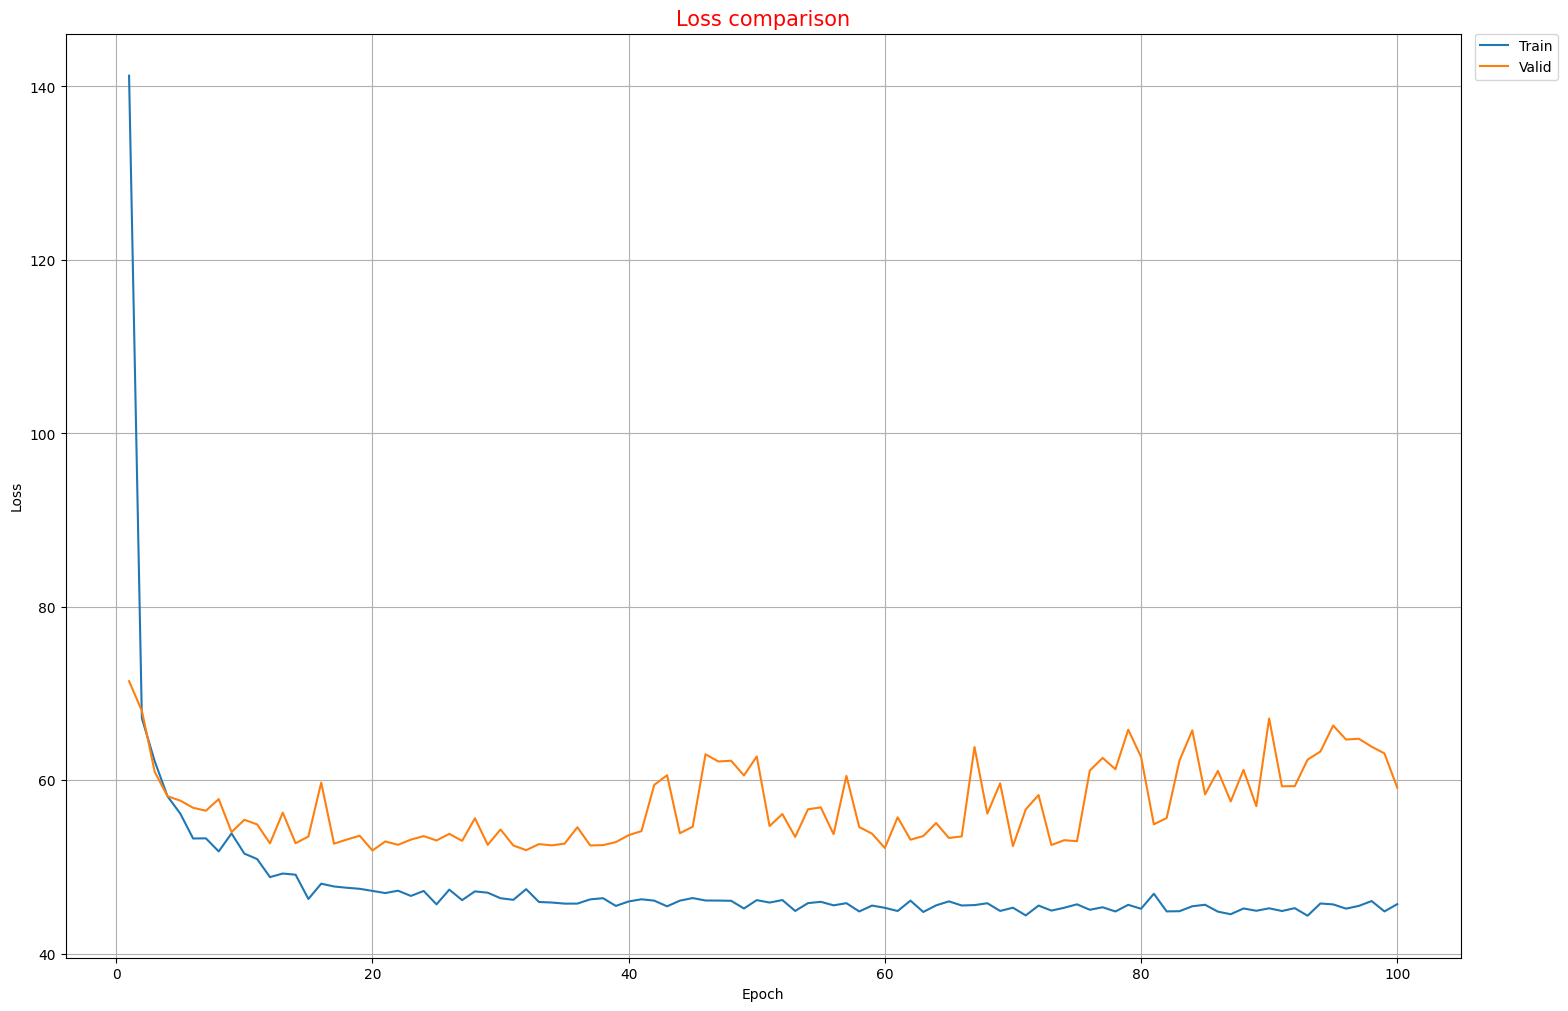

In [32]:
plot_data(training_data, 'Loss')

学習をしたことで、そのモデル自体とロスの推移の情報をそれぞれ `model` と `training_data` で受け取れました。

上のコードではロスの推移をグラフ化したものになります。

`plot_data` 関数内の引数に `mode` というものがありますが、これは学習のときに `Loss` という辞書のインデックスを付けたやつです。

ここでは `mode` は `Loss` の1種類しかありませんが、他に見たいものがあるかもしれないので一応引数として取っておき、学習のプログラム内に追記しても大丈夫なようにはしておきましたが、特に使わないかなと思います。

In [33]:
def torch_compare_preds(y_eval, y_pred):
    y_pred = y_pred.detach().numpy()

    plt.figure(figsize=(18, 12))
    plt.grid()

    plt.plot(y_eval, label='correct')
    plt.plot(y_pred, label='prediction')

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()

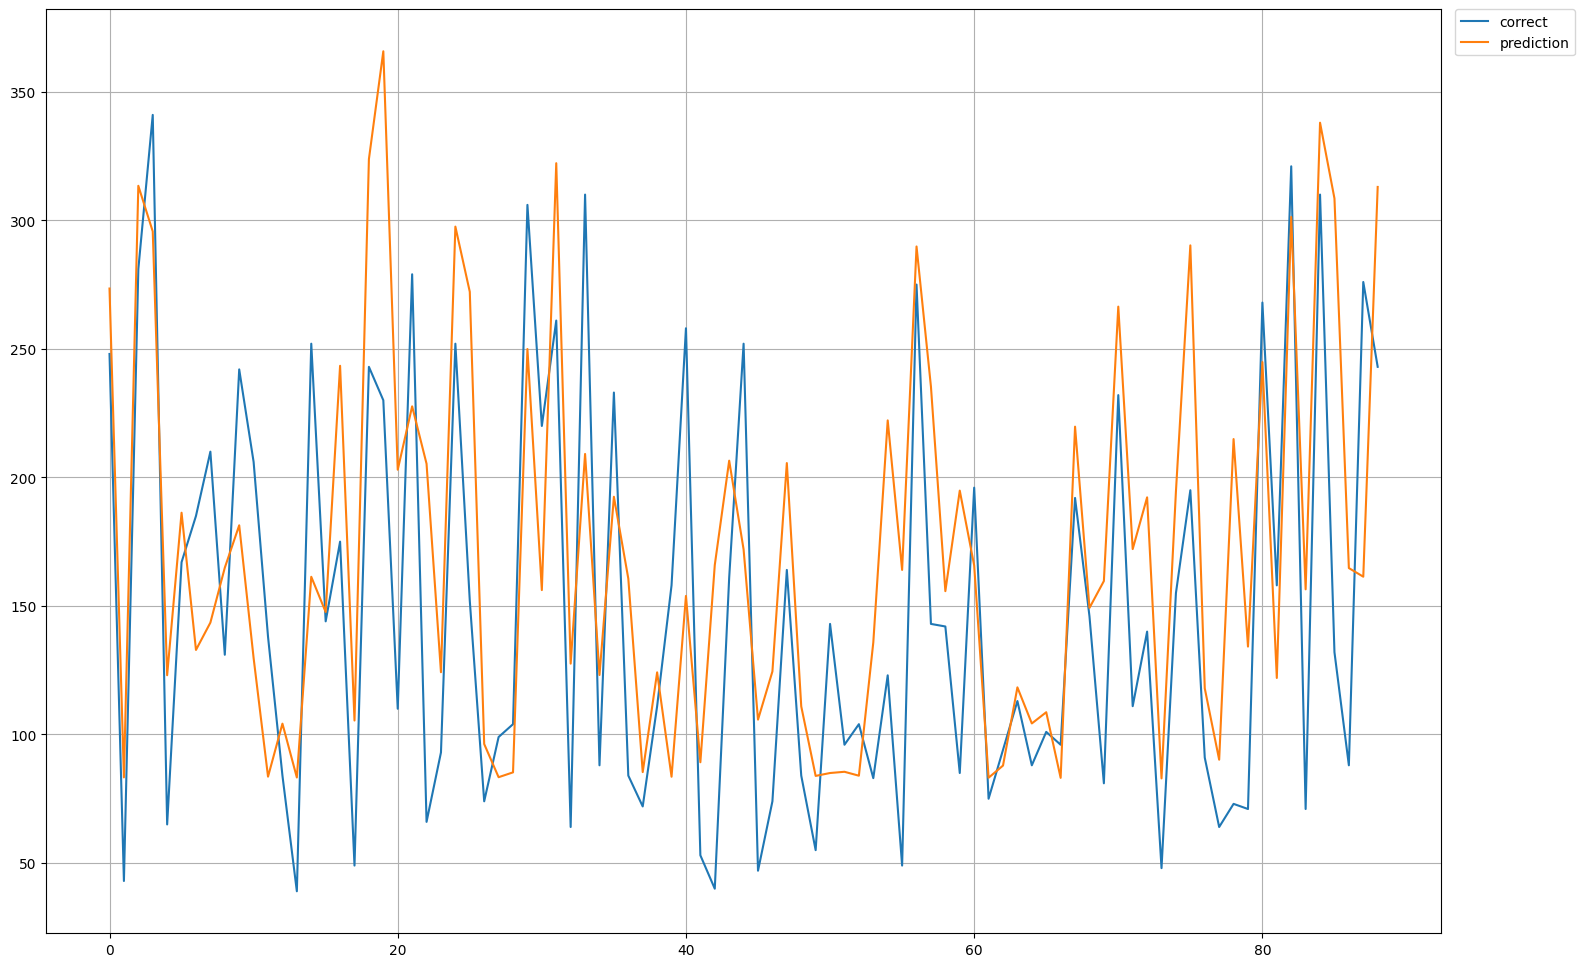

In [34]:
y_pred = model(X_eval)
torch_compare_preds(y_eval, y_pred)

真の値の `y_eval` と予測値の `y_pred` を引数に取った関数 `compare_preds` で予測にどれくらい差があるのかを可視化しました。

### 全体コード

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.optim import SGD
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm


if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        outputs = self.linear_relu_stack(x)
        return outputs

In [ ]:
def list_to_torch(X, y):
    X = np.array(X)
    y = np.array(y)

    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).float()

    return X, y
        

def model_train(epochs, train_dataloader, valid_dataloader, model, optimizer, criterion, batch_size):
    dataloader_dict = {
        'Train': train_dataloader,
        'Valid': valid_dataloader
    }

    training_data = []
    with tqdm(range(epochs)) as pbar_epoch:
        for epoch in pbar_epoch:
            pbar_epoch.set_description(f'epoch : {epoch + 1}')
            metas = []
            for phase in ['Train', 'Valid']:
                if phase == 'Train':
                    model.train()
                else:
                    model.eval()

                epoch_loss = 0.0

                for inputs, label in dataloader_dict[phase]:
                    inputs = inputs.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'Train'):
                        outputs = model(inputs)
                        loss = criterion(outputs, label) ** 0.5

                        if phase == 'Train':
                            loss.backward()
                            optimizer.step()

                        epoch_loss += loss.item() * inputs.size(0)

                epoch_loss = epoch_loss / (len(dataloader_dict[phase].dataset) * batch_size)

                meta = {'Loss': epoch_loss}
                metas.append(meta)

            training_data.append(dict(zip(['Train', 'Valid'], metas)))
    
    return model, training_data


def plot_data(training_data, mode):
    train_y = [training_data[i]['Train'][mode] for i in range(len(training_data))]
    valid_y = [training_data[i]['Valid'][mode] for i in range(len(training_data))]

    x = [i + 1 for i in range(len(train_y))]

    plt.figure(figsize=(18, 12))
    plt.title(f'{mode} comparison', size=15, color='red')
    plt.grid()

    plt.plot(x, train_y, label='Train')
    plt.plot(x, valid_y, label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel(mode)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()


def torch_compare_preds(y_eval, y_pred):
    y_pred = y_pred.detach().numpy()

    plt.figure(figsize=(18, 12))
    plt.grid()

    plt.plot(y_eval, label='correct')
    plt.plot(y_pred, label='prediction')

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.show()

In [ ]:
data = load_diabetes()

X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=8192)
X_valid, X_eval, y_valid, y_eval = train_test_split(X_test, y_test, test_size=0.50, random_state=8192)

X_train, y_train = list_to_torch(X_train, y_train)
X_valid, y_valid = list_to_torch(X_valid, y_valid)
X_eval, y_eval = list_to_torch(X_eval, y_eval)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

batch_size = 1

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
model = NeuralNetwork().to(device)
optimizer = SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

model, training_data = model_train(
    epochs=100,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    batch_size=batch_size
)

plot_data(training_data, 'Loss')

In [ ]:
y_pred = model(X_eval)
torch_compare_preds(y_eval, y_pred)